# KC  email conversion

In [ ]:
!pip install ipython-sql

In [ ]:
#!pip install -U numpy

In [ ]:
#!python --version

In [ ]:
#import sklearn
#print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [1]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import learning_curve

%matplotlib inline


## Read Data

In [2]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = 'redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']
connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
query="""
SELECT * FROM ml_prep.gauthier_offer_load_all_kc_2019_2020_dataset ;
"""
df = pd.read_sql_query(query, con)
df.head(3)


event_time                          request_id  partner_id  \
0  2019-06-05T05:21:51Z  k4rPxwyv5Q0WeRPKD6EhjssQEzRLY3GjCA         387   
1  2019-06-05T06:33:09Z  hWzQ2i5fgFDbd9UHF1jGlbszoGWFSVWL27         387   
2  2019-06-09T04:20:24Z  LE2vYhoBUJBCC2ehL2Zuh37Nw6YDQuLtiN         387   

  origin destination  flight_number departure_date departure_time from_cabin  \
0    TSE         FRA            921     2019-06-07          16:10    ECONOMY   
1    KZN         TSE            160     2019-06-21          15:00    ECONOMY   
2    TSE         FRA            921     2019-06-12          16:10    ECONOMY   

  upgrade_type  ... last_email_opened_time  email_opened_count  \
0     BUSINESS  ...    2019-06-05 05:21:20                   4   
1     BUSINESS  ...    2019-06-05 06:32:40                   4   
2     BUSINESS  ...                    NaT                   0   

  first_email_clicked_time last_email_clicked_time email_clicked_count  \
0                     None                    None                   0   
1                     None                    None                   0   
2                     None                    None                   0   

   offer_amount_usd  offer_amount_total_usd offer_quantity offer_customer_id  \
0               NaN                     NaN           None              None   
1               NaN                     NaN           None              None   
2               NaN                     NaN           None              None   

  offer_type  
0     NO_BID  
1     NO_BID  
2     NO_BID  

[3 rows x 50 columns]

# Exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189629 entries, 0 to 189628
Data columns (total 50 columns):
event_time                            189629 non-null object
request_id                            189629 non-null object
partner_id                            189629 non-null int64
origin                                189629 non-null object
destination                           189629 non-null object
flight_number                         189629 non-null int64
departure_date                        189629 non-null object
departure_time                        189629 non-null object
from_cabin                            189629 non-null object
upgrade_type                          189629 non-null object
first_offer_load_time                 189629 non-null object
offer_load_count                      189629 non-null int64
currency                              189629 non-null object
pnr                                   189629 non-null object
language                              

In [ ]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    
def plot_categories( df , cat , target , size=4, aspect=2, **kwargs):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col, size = size, aspect = aspect  )
    facet.map( sns.barplot , cat , target, order=None )
    facet.add_legend()


In [ ]:
plot_distribution( df , var = 'duration' , target = 'offer_type' )

In [ ]:
plot_distribution( df , var = 'pax' , target = 'offer_type' )

# Feature Engineering

In [5]:
#drop non relevant fields
df = df.drop(['distance_unit', 'request_id', 'slider_min','slider_max', 'slider_step', 'pnr', 
         'instant_upgrade_eligibility_reason', 'eligibility_reason', 'instant_upgrade_eligibility','slider_step'
        ], axis=1)



In [6]:
# compute some time-related features
# this takes some time
df['departure_hour'] = pd.to_datetime(df['departure_time']).apply(lambda x: x.hour)
df['departure_day_of_week']= pd.to_datetime(df['departure_date']).apply(lambda x: x.dayofweek)
df['departure_month']= pd.to_datetime(df['departure_date']).apply(lambda x: x.month)
df['event_day_of_week']= pd.to_datetime(df['event_time']).apply(lambda x: x.dayofweek)
df['event_hour']= pd.to_datetime(df['event_time']).apply(lambda x: x.hour)
df['event_month']= pd.to_datetime(df['event_time']).apply(lambda x: x.month)
df['origin_destination'] = df['origin']+ df['destination']
df["days_before_departure"] =(pd.to_datetime(df["departure_date"])-pd.to_datetime(df["event_time"]).dt.tz_localize(None)).apply(lambda x: x.days)
df["days_since_first_offer_load"] = (pd.to_datetime(df["event_time"]) - pd.to_datetime(df["first_offer_load_time"])).apply(lambda x: x.days)
df["first_offer_load_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["first_offer_load_time"]).dt.tz_localize(None)).apply(lambda x: x.days)

df["first_email_sent_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_sent_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_sent"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_sent"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["first_email_opened_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_opened_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_opened"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_opened"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["first_email_clicked_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_clicked_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_clicked"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_clicked"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["days_between_first_last_email_sent"] = (pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_between_first_last_email_opened"] = (pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_between_first_last_email_clicked"] = (pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)



In [7]:
df.head(3)

event_time  partner_id origin destination  flight_number  \
0  2019-06-05T05:21:51Z         387    TSE         FRA            921   
1  2019-06-05T06:33:09Z         387    KZN         TSE            160   
2  2019-06-09T04:20:24Z         387    TSE         FRA            921   

  departure_date departure_time from_cabin upgrade_type first_offer_load_time  \
0     2019-06-07          16:10    ECONOMY     BUSINESS  2019-06-05T05:21:42Z   
1     2019-06-21          15:00    ECONOMY     BUSINESS  2019-06-05T06:33:02Z   
2     2019-06-12          16:10    ECONOMY     BUSINESS  2019-06-08T04:02:45Z   

   ...  last_email_opened_days_before_departure days_since_first_email_opened  \
0  ...                                        1                            12   
1  ...                                       15                            11   
2  ...                                        0                             0   

  days_since_last_email_opened  first_email_clicked_days_before_departure  \
0                            0                                          0   
1                            0                                          0   
2                            0                                          0   

   last_email_clicked_days_before_departure days_since_first_email_clicked  \
0                                         0                              0   
1                                         0                              0   
2                                         0                              0   

  days_since_last_email_clicked days_between_first_last_email_sent  \
0                             0                                 14   
1                             0                                  1   
2                             0                                 14   

  days_between_first_last_email_opened  days_between_first_last_email_clicked  
0                                   12                                      0  
1                                   11                                      0  
2                                    0                                      0  

[3 rows x 66 columns]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189629 entries, 0 to 189628
Data columns (total 66 columns):
event_time                                   189629 non-null object
partner_id                                   189629 non-null int64
origin                                       189629 non-null object
destination                                  189629 non-null object
flight_number                                189629 non-null int64
departure_date                               189629 non-null object
departure_time                               189629 non-null object
from_cabin                                   189629 non-null object
upgrade_type                                 189629 non-null object
first_offer_load_time                        189629 non-null object
offer_load_count                             189629 non-null int64
currency                                     189629 non-null object
language                                     189629 non-null object
pax     

# Feature Encoding

In [9]:
# for random forest, no need to one-hot-encode
def label_encode_categorical(df, columns):
    train_df_fact = df.copy()
    for column in columns:
        print('label encoding',column,'...')
        encoder = preprocessing.LabelEncoder()
        encoder.fit(train_df_fact[column])
        train_df_fact[column+'_encoded'] = encoder.transform(train_df_fact[column])
    return train_df_fact


In [10]:
# label-encode categories
df= label_encode_categorical(df,['origin','channel_source','destination','origin_destination','language','point_of_sale','equipment'])

label encoding origin ...
label encoding channel_source ...
label encoding destination ...
label encoding origin_destination ...
label encoding language ...
label encoding point_of_sale ...
label encoding equipment ...


# Label encode

In [11]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(df['offer_type'])
df['offer_type_encoded'] = label_encoder.transform(df['offer_type'])

In [12]:
label_encoder.classes_

array(['BUSINESS', 'NO_BID', 'PREMIUM_ECONOMY'], dtype=object)

In [13]:
df.head(3)

event_time  partner_id origin destination  flight_number  \
0  2019-06-05T05:21:51Z         387    TSE         FRA            921   
1  2019-06-05T06:33:09Z         387    KZN         TSE            160   
2  2019-06-09T04:20:24Z         387    TSE         FRA            921   

  departure_date departure_time from_cabin upgrade_type first_offer_load_time  \
0     2019-06-07          16:10    ECONOMY     BUSINESS  2019-06-05T05:21:42Z   
1     2019-06-21          15:00    ECONOMY     BUSINESS  2019-06-05T06:33:02Z   
2     2019-06-12          16:10    ECONOMY     BUSINESS  2019-06-08T04:02:45Z   

   ...  days_between_first_last_email_opened  \
0  ...                                    12   
1  ...                                    11   
2  ...                                     0   

  days_between_first_last_email_clicked origin_encoded  \
0                                     0             35   
1                                     0             22   
2                                     0             35   

   channel_source_encoded  destination_encoded origin_destination_encoded  \
0                      22                   11                         93   
1                      22                   35                         64   
2                       1                   11                         93   

  language_encoded point_of_sale_encoded equipment_encoded  offer_type_encoded  
0               19                     0                 5                   1  
1               14                     0                 6                   1  
2               10                     0                 5                   1  

[3 rows x 74 columns]

In [14]:
columns_for_training= [
                       # departure time
                       'departure_hour',
                       'departure_day_of_week',
                       'departure_month',
                       # event time
                       'event_hour',
                       'event_day_of_week',
                       'event_month',
                       'days_before_departure',
                       # route
                       'origin_encoded', 
                       'destination_encoded',
                       'origin_destination_encoded',
                       'duration', 
                       'distance', 
                       # the rest
                       'channel_source_encoded',
                       'language_encoded',
                       'pax',
                       'point_of_sale_encoded',
                       'equipment_encoded',
                       # slider
                       'slider_max_usd',        
                       'slider_min_usd',        
                       'slider_start_usd',  
                       # previous offer loads
                        'offer_load_count',
                        'days_since_first_offer_load',
                        'first_offer_load_days_before_departure',
                       # email 
                        'first_email_sent_days_before_departure',
                        'last_email_sent_days_before_departure',
                        'days_since_first_email_sent',
                        'days_since_last_email_sent',
                        'first_email_opened_days_before_departure',
                        'last_email_opened_days_before_departure',
                        'days_since_first_email_opened',
                        'days_since_last_email_opened',
                        'first_email_clicked_days_before_departure',
                        'last_email_clicked_days_before_departure',
                        'days_since_first_email_clicked',
                        'days_since_last_email_clicked',
                        'days_between_first_last_email_sent',
                        'days_between_first_last_email_opened',
                        'days_between_first_last_email_clicked',
                        'email_sent_count',
                        'email_opened_count',
                        'email_clicked_count',
                       # target
                        'offer_type_encoded',
                      ]

df = df[columns_for_training]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189629 entries, 0 to 189628
Data columns (total 42 columns):
departure_hour                               189629 non-null int64
departure_day_of_week                        189629 non-null int64
departure_month                              189629 non-null int64
event_hour                                   189629 non-null int64
event_day_of_week                            189629 non-null int64
event_month                                  189629 non-null int64
days_before_departure                        189629 non-null int64
origin_encoded                               189629 non-null int64
destination_encoded                          189629 non-null int64
origin_destination_encoded                   189629 non-null int64
duration                                     189629 non-null int64
distance                                     189629 non-null int64
channel_source_encoded                       189629 non-null int64
language_encoded  

In [16]:
df.head(4)

departure_hour  departure_day_of_week  departure_month  event_hour  \
0              16                      4                6           5   
1              15                      4                6           6   
2              16                      2                6           4   
3              16                      2                6           4   

   event_day_of_week  event_month  days_before_departure  origin_encoded  \
0                  2            6                      1              35   
1                  2            6                     15              22   
2                  6            6                      2              35   
3                  6            6                      2              35   

   destination_encoded  origin_destination_encoded  ...  \
0                   11                          93  ...   
1                   35                          64  ...   
2                   11                          93  ...   
3                   11                          93  ...   

   last_email_clicked_days_before_departure  days_since_first_email_clicked  \
0                                         0                               0   
1                                         0                               0   
2                                         0                               0   
3                                         0                               0   

   days_since_last_email_clicked  days_between_first_last_email_sent  \
0                              0                                  14   
1                              0                                   1   
2                              0                                  14   
3                              0                                  14   

   days_between_first_last_email_opened  \
0                                    12   
1                                    11   
2                                     0   
3                                     0   

   days_between_first_last_email_clicked  email_sent_count  \
0                                      0                 4   
1                                      0                 4   
2                                      0                 6   
3                                      0                 6   

   email_opened_count  email_clicked_count  offer_type_encoded  
0                   4                    0                   1  
1                   4                    0                   1  
2                   0                    0                   1  
3                   0                    0                   1  

[4 rows x 42 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f277db67da0>]],
      dtype=object)

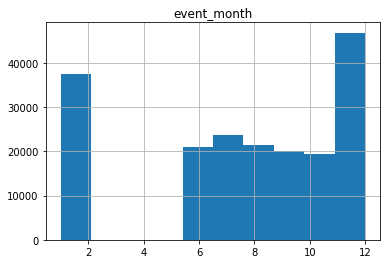

In [17]:
# we could use month to split train/test data
pd.DataFrame.hist(df,column='event_month')

# Model Training & Evaluation

In [18]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cbar=False)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [20]:
def train_and_evaluate(df_to_train, plot_learning_curves=False, limit=None, split_on_time=False):
    # X-validation
    from sklearn.preprocessing import label_binarize
    from sklearn.multiclass import OneVsRestClassifier
    
    if limit is not None:
        #pick them randomly
        df_to_train = df_to_train.sample(n=limit)

    random_forest =  OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
    X = df_to_train.drop("offer_type_encoded", axis=1)
    y_raw = df_to_train["offer_type_encoded"]
    
    y = label_binarize(y_raw, classes=[0, 1, 2])

    n_classes = y.shape[1]
    
    if split_on_time:
        # if event_month is greater than 8 it means we are in 2019 (TRAIN SET) otherwise we are in 2020 (TEST SET)
        X_train = X[X["event_month"] >=8]
        y_train = y[X["event_month"] >=8]
        X_test = X[X["event_month"] <8]
        y_test = y[X["event_month"] <8]
        pass
    else:
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)

    # train
    print('training on', str(len(X_train)), 'rows...')
    random_forest.fit(X_train, y_train)
    print('training is done!')
    print('testing on', str(len(X_test)), 'rows...')

    # predict
    y_test_proba = random_forest.predict_proba(X_test)
    y_test_predict = random_forest.predict(X_test)

    #print('y_test_proba',y_test_proba)
    #print('y_test_predict',y_test_predict)
    # evaluation metrics

    roc_auc = dict()
    
    colors = ['red', 'blue', 'green']
    
    plt.figure(figsize=(16,9))
    for i,color in zip(range(n_classes),colors):
        fpr, tpr, _ = metrics.roc_curve(y_test[:, i], y_test_proba[:, i])
        plt.title('ROC')
        plt.plot([0, 1], [0,1], 'k--')
        roc_auc_for_one_class=metrics.auc(fpr, tpr)
        roc_auc[i] = roc_auc_for_one_class
        plt.plot(fpr, tpr,marker='.',color=color, label='{0} (AUC = {1:0.2f})'.format(label_encoder.classes_[i], roc_auc_for_one_class))
        plt.legend(loc="center right")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
    roc_auc = metrics.roc_auc_score(y_test,y_test_proba,multi_class="ovr")
    
    print('global roc_auc',roc_auc)
    
    
    plt.figure(figsize=(16,9))
    for i,color in zip(range(n_classes),colors):
        precisions, recalls, thresholds = metrics.precision_recall_curve(y_test[:, i], y_test_proba[:, i])
        plt.title('Precision-Recall')
        roc_pr_for_one_class=metrics.auc(recalls, precisions)
        plt.plot(recalls, precisions,marker='.',color=color, label='{0} (AUC = {1:0.2f})'.format(label_encoder.classes_[i], roc_pr_for_one_class))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="center right")
        # proportion of positive examples
        #no_skill = len(y[y==1]) / len(y)
        #plt.plot([0, 1], [no_skill, no_skill], linestyle='--')

    #print('precisions',precisions)
    #print('recalls',recalls)
    #print('thresholds',thresholds)

    precision,recall,f1,support = metrics.precision_recall_fscore_support(y_test,y_test_predict)

    for i in range(n_classes):
        print('#### CLASS',label_encoder.classes_[i],'####')
        print('precision', precision[i])
        print('recall', recall[i])
        print('f1', f1[i])
        print('support', support[i])

    cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_test_predict.argmax(axis=1))
    print_confusion_matrix(cm, label_encoder.classes_)
    
    
    
    for i in range(n_classes):
        features = X_train.columns
        importances = random_forest.estimators_[i].feature_importances_
        indices = np.argsort(importances)[::-1]
        print('# KC offer type prediction. Feature importance for',label_encoder.classes_[i])
        for feature,importance in zip(features[indices],importances[indices]):
            print(feature+','+str(importance))
    
        # Plot the impurity-based feature importances of the forest
        plt.figure(figsize=(16,9))
        plt.title('Feature Importances for class '+ label_encoder.classes_[i])
        plt.bar(range(len(indices)), importances[indices], color='b', align='center')   
        plt.xticks(range(X_train.shape[1]), features[indices],rotation=90)
    
    if plot_learning_curves:
        scoring = 'roc_auc'
        print('Computing Learning curves...')
        train_sizes, train_scores, test_scores = \
                learning_curve(random_forest, X, y, train_sizes=np.linspace(0.1, 1.0, 5), scoring=scoring, cv=2)

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(16,9))
        # Plot learning curve
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        plt.legend(loc="best")
        plt.xlabel("Training examples")
        plt.ylabel(scoring)
        plt.title("Learning Curves")


        print(train_sizes)
        print(train_scores)
        print(test_scores)


training on 132740 rows...
training is done!
testing on 56889 rows...
global roc_auc 0.8939109606867275
#### CLASS BUSINESS ####
precision 0.5654008438818565
recall 0.08915502328675981
f1 0.1540229885057471
support 1503
#### CLASS NO_BID ####
precision 0.9755787466228744
recall 0.9979768786127168
f1 0.9866507130037236
support 55360
#### CLASS PREMIUM_ECONOMY ####
precision 1.0
recall 0.07692307692307693
f1 0.14285714285714288
support 26
# KC offer type prediction. Feature importance for BUSINESS
offer_load_count,0.06686226588707146
slider_start_usd,0.06114647612763108
slider_max_usd,0.05999654974859185
slider_min_usd,0.0574582640058699
event_hour,0.056685955880245414
days_before_departure,0.04633415313376345
first_offer_load_days_before_departure,0.04533912570833336
event_day_of_week,0.03606295891607549
departure_month,0.03572676211621512
distance,0.035655102348807664
duration,0.035551170518732494
language_encoded,0.03548514174390869
event_month,0.03403329338497015
channel_source_encod

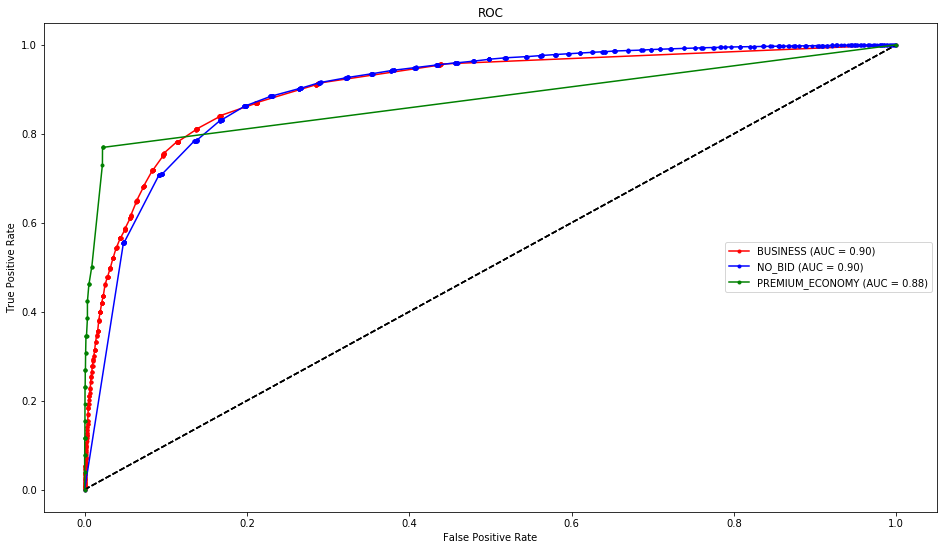

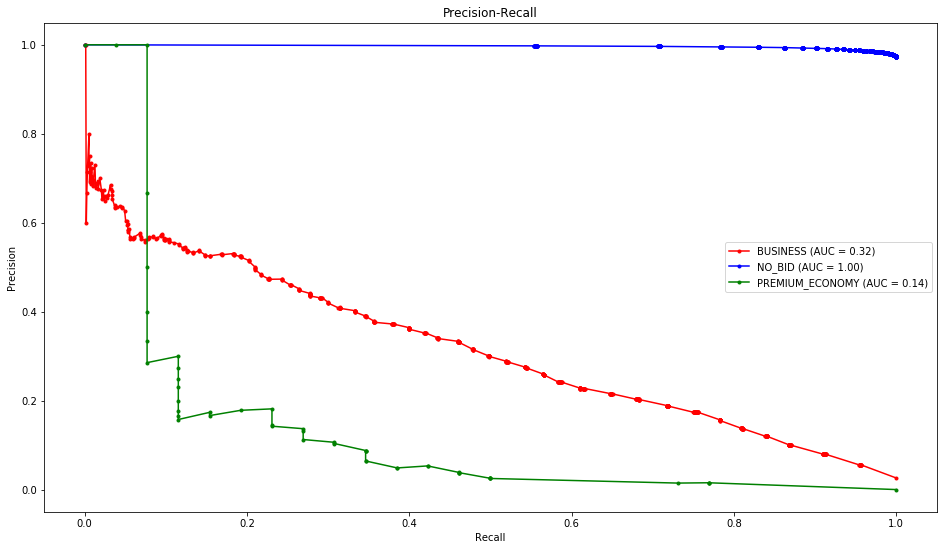

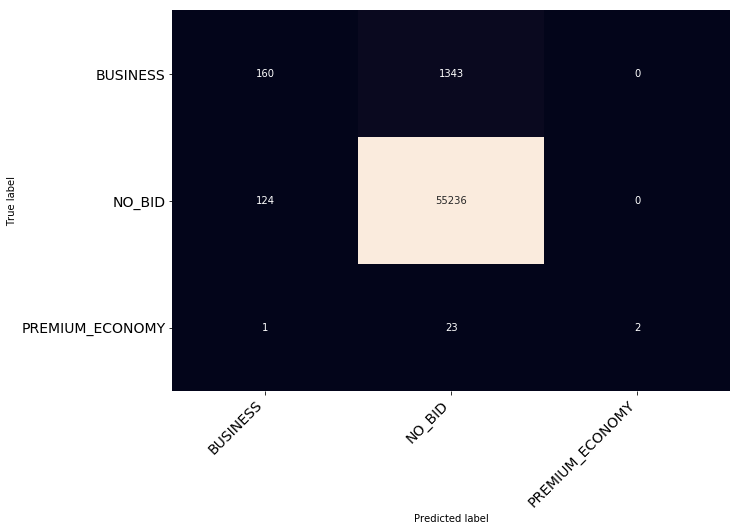

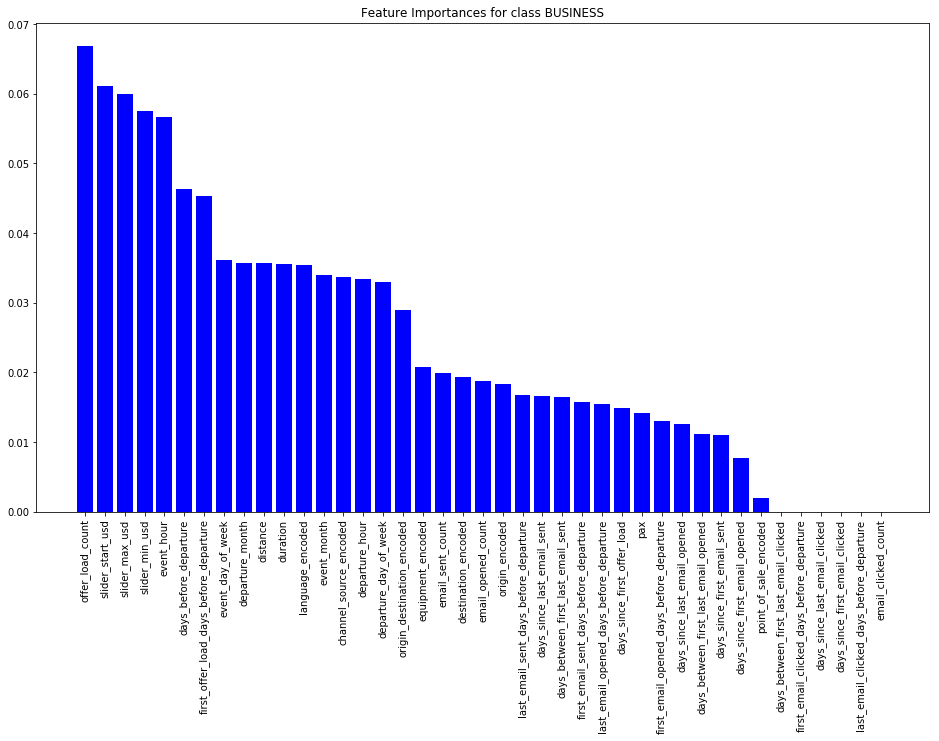

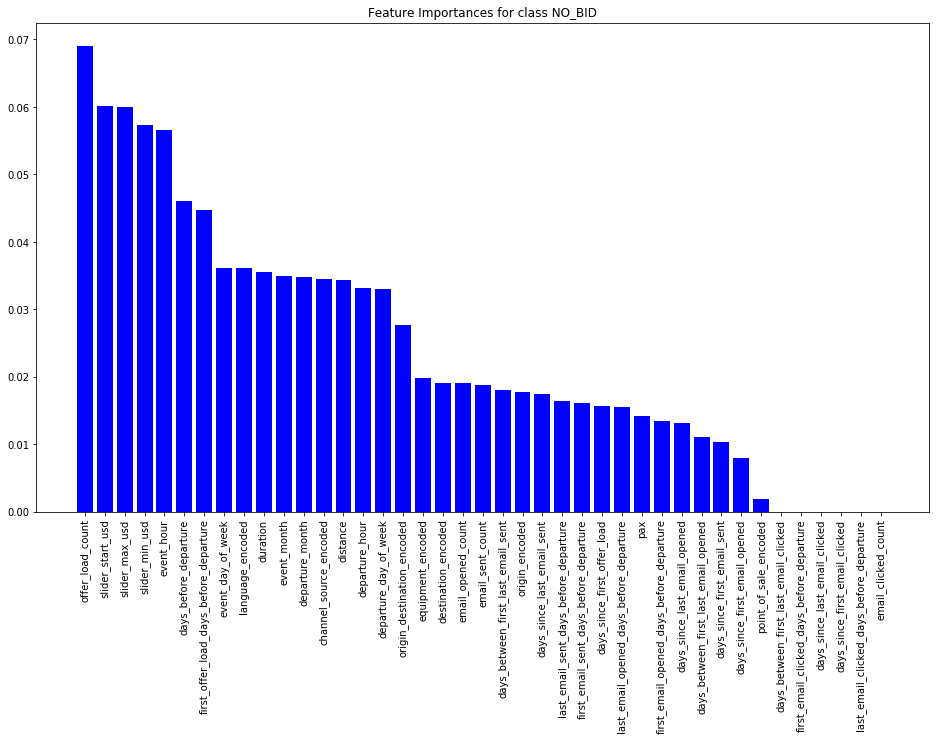

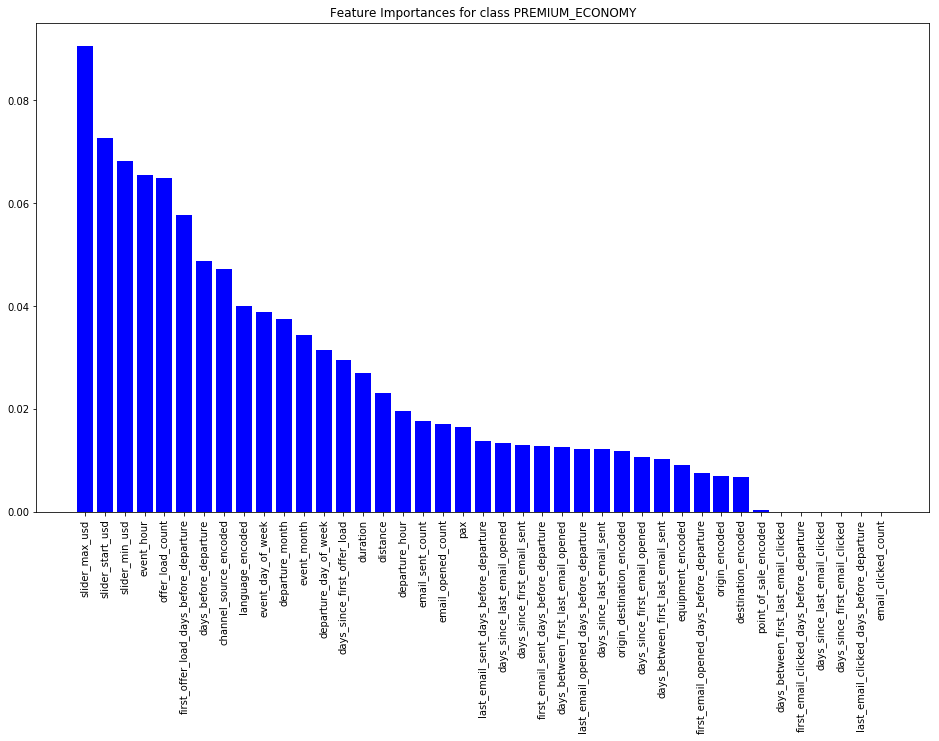

In [21]:
train_and_evaluate(df,plot_learning_curves=False,limit=None)